In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

## Анализ данных

In [2]:
import matplotlib.pyplot as plt

class Plotter(object):
    def __init__(self, X, y1, y2=None, header=None):
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.header = header

    @staticmethod
    def plot_2d_scatter(X, y, ax, name, features, header):
        try:
            label = []
            for _ in y:
                if _ == 0:
                    label.append("purple")
                elif _ == 1:
                    label.append("orange")
                elif _ == 2:
                    label.append("red")
            
            f1_values = X[:, features][:, 0]
            f2_values = X[:, features][:, 1]

            ax.scatter(f1_values, f2_values, c=label)
            ax.set_title(name)
            ax.set_xlabel(header[features[0]])
            ax.set_ylabel(header[features[1]])

        except TypeError as e:
            print("\nNo label data was provided.\n")
            raise e

    @staticmethod 
    def save_to_file(path):
        plt.savefig(path)
        plt.close()

    def horizontal_plots(self, features: tuple):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        fig.tight_layout(pad=5.0)

        name_true = "Y True"
        name_pred = "Predicted Clusters"

        self.plot_2d_scatter(self.X, self.y1, ax1, name_true,
                             features, self.header)
        self.plot_2d_scatter(self.X, self.y2, ax2, name_pred,
                             features, self.header)

        self.save_to_file(f"../output/{features}.png")


    def saveall_2d_scatter(self):
        count_features = self.X.shape[1]

        for f1 in range(count_features):
            for f2 in range(count_features):
                if f1 == f2:
                    continue
                else:
                    self.horizontal_plots((f1, f2))


In [262]:
def norm_data(data: pd.DataFrame):
    norm_data = data.copy()
    for column in data.columns:
        maximum = data[column].max()
        minimum = data[column].min()
        norm_data[column] = (norm_data[column] - minimum) / (maximum - minimum)
    return norm_data

def plot_heatmap(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True)
    plt.show()

def plot_clusters(x: np.ndarray, clusters: np.ndarray, features: tuple, title=None, center_points=None):
    plt.figure(figsize=(10, 6))
    f1, f2 = features
    cluster_list = set(clusters)
    for c in cluster_list:
        if c == -1:
            plt.plot(x[clusters == c, f1], x[clusters == c, f2], "o", markersize=8, color='k', label=f'Cluster {c}')
        else:
            plt.plot(x[clusters == c, f1], x[clusters == c, f2], "o", markersize=8, label=f'Cluster {c}')
    
    # Отображаем центроиды кластеров для KMeans
    if isinstance(center_points, np.ndarray):
        for point in center_points:
            plt.scatter(point[f1], point[f2], s=120, color='k')   
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

def plot_outliers(data):
    num_columns = len(data.columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(num_columns*2,6))
    fig.suptitle('Outliers\n', size = 25)
    for i, column in enumerate(data.columns):
        sns.boxplot(ax=axes[i], data=data[column]).set_title(column)
    plt.tight_layout()

def plot_dbscan_points (
        X: np.ndarray, 
        clusters: np.ndarray, 
        core_points: np.ndarray, 
        features_indexes: tuple=(2,3),
        skip_noise=False
    ):
    """Строит результат кластеризации совместно с главными(core) точками"""
    core_samples_mask = np.zeros_like(clusters)
    core_samples_mask[core_points] = True

    f1, f2 = features_indexes
    
    cluster_label = set(clusters)#np.unique(clusters)

    # colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(cluster_label))]
    for k in cluster_label:
        if k == -1:
            if skip_noise:
                continue
            # Black used for noise.
            xy = X[clusters == k]
            plt.plot(xy[:, f1], xy[:, f2], "o", 
                    markeredgecolor="k", markersize=6, color='k')
        else:
            xy = X[clusters == k & core_samples_mask]
            plt.plot(xy[:, f1], xy[:, f2], "o",
                markeredgecolor="k", markersize=14)

            xy = X[clusters == k & ~core_samples_mask]
            plt.plot(xy[:, f1], xy[:, f2], "o",  
                    markeredgecolor="k", markersize=6)


def print_f1_scores(y: np.ndarray, hc_clusters: np.ndarray):
    print("F1 micro: ", f1_score(y, hc_clusters, average="micro"))
    print("F1 macro: ", f1_score(y, hc_clusters, average="macro"))
    print("F1 weighted: ", f1_score(y, hc_clusters, average="weighted"))
    print('\n')


def hc_labels(clusters: np.ndarray, label_order: list) -> np.ndarray:
    hc_clusters = np.zeros_like(clusters)
    clusters_ids = np.unique(clusters)

    for cls, true_label in zip(clusters_ids, label_order):
        hc_clusters [clusters == cls] = true_label
    return hc_clusters


In [432]:
from sklearn.datasets import load_iris
iris_ds = load_iris(as_frame=True)
X_iris = iris_ds['data'].to_numpy()
y_iris = iris_ds['target'].to_numpy()
data = iris_ds['frame']

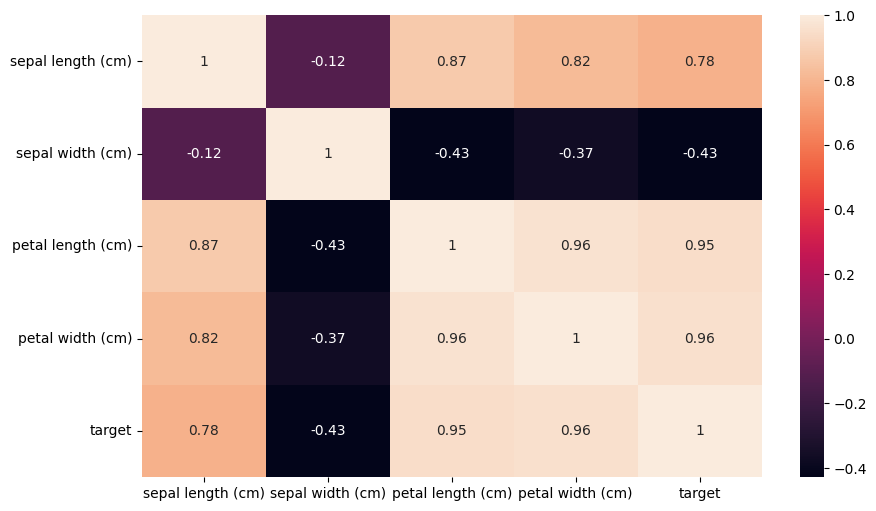

In [9]:
plot_heatmap(data)

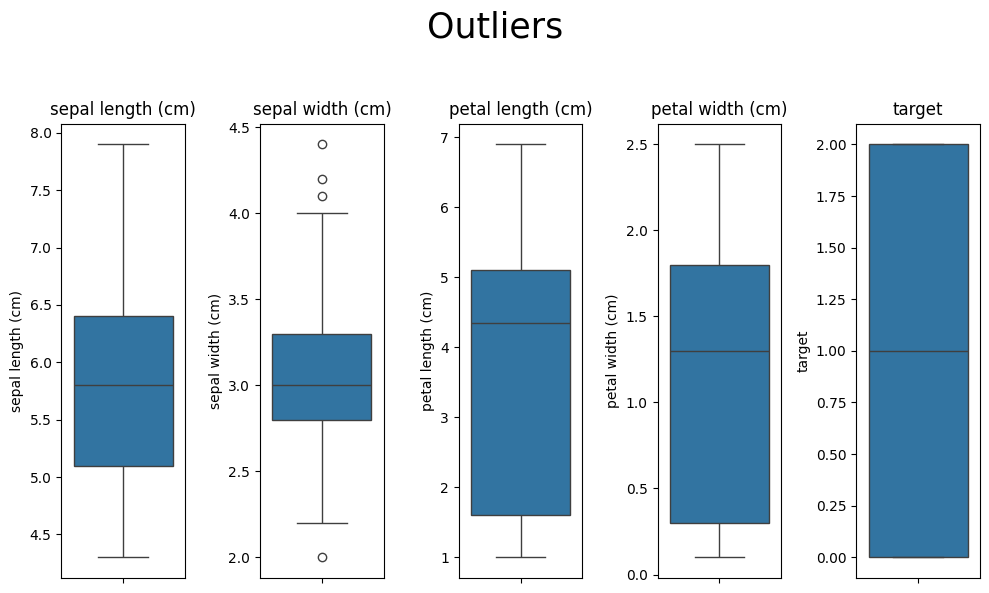

In [21]:
plot_outliers(data)

In [429]:
data[(data['sepal width (cm)'] > 4) | (data['sepal width (cm)'] < 2.1)]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
15,5.7,4.4,1.5,0.4,0
32,5.2,4.1,1.5,0.1,0
33,5.5,4.2,1.4,0.2,0
60,5.0,2.0,3.5,1.0,1


In [433]:
data = data.drop(columns='target')
n_data = norm_data(data)
X_normed = n_data.to_numpy()
n_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


# Кластеризация

In [170]:
# Задаём гипер параметры методов

hyper = {
    "KMeans": {
        "n_clusters": 3,
        "init": "k-means++", # or "random".
        "n_init": "auto",
        "max_iter": 100, # default 300.
        "tol": 0.1, # default is 0.0001.
        "algorithm": "lloyd", # or "elkan".
        "random_state": 42
    },
    "DBSCAN": {
        "eps": 0.8, 
        "min_samples": 14, 
        "metric": 'l1',
    },
    "Hierarchical": {
        "n_clusters": 3,
        "compute_distances": True,
    }
}

## K-Means

F1 micro:  0.9
F1 macro:  0.8982809480215646
F1 weighted:  0.8982809480215644




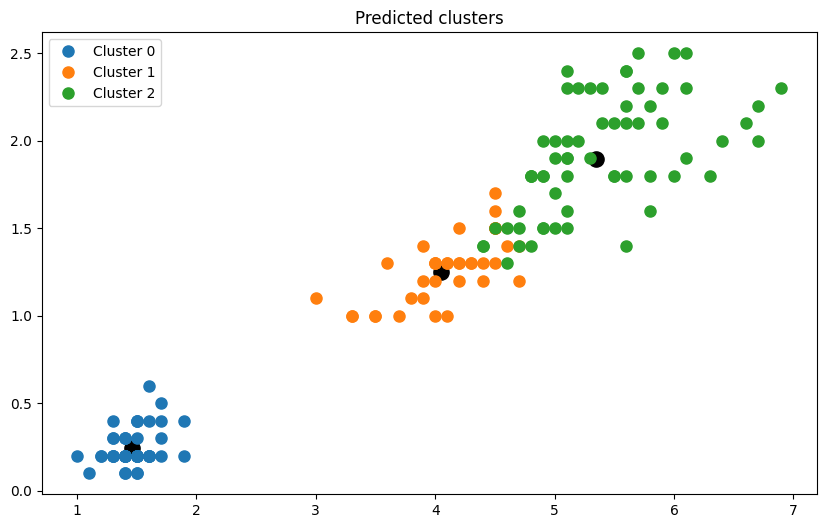

In [258]:
from sklearn.cluster import KMeans

kmeans = KMeans(**hyper['KMeans'])
km = kmeans.fit(X_iris)
clusters = km.labels_
cluster_centers = km.cluster_centers_

label_order = [2, 0, 1]
corrected_clusters = hc_labels(clusters, label_order)
print_f1_scores(y_iris, corrected_clusters)
plot_clusters(X_iris, corrected_clusters, (2,3), title='Predicted clusters', center_points=cluster_centers)

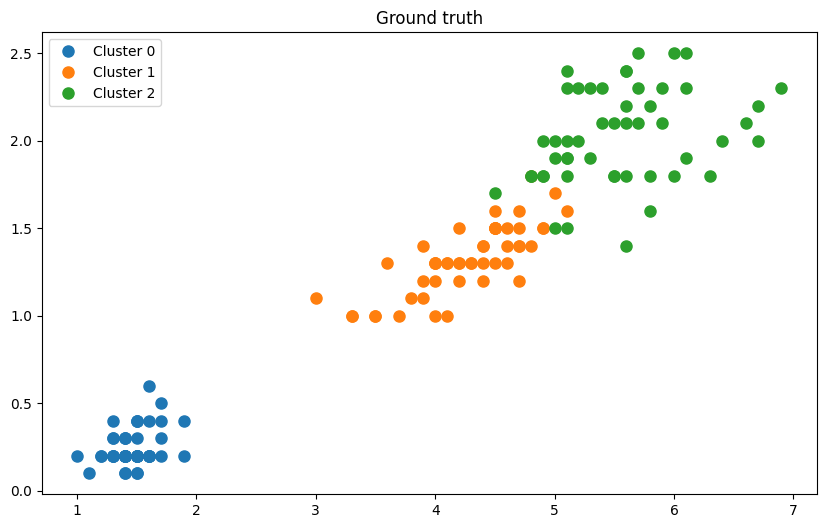

In [259]:
plot_clusters(X_iris, y_iris, (2,3), title='Ground truth')

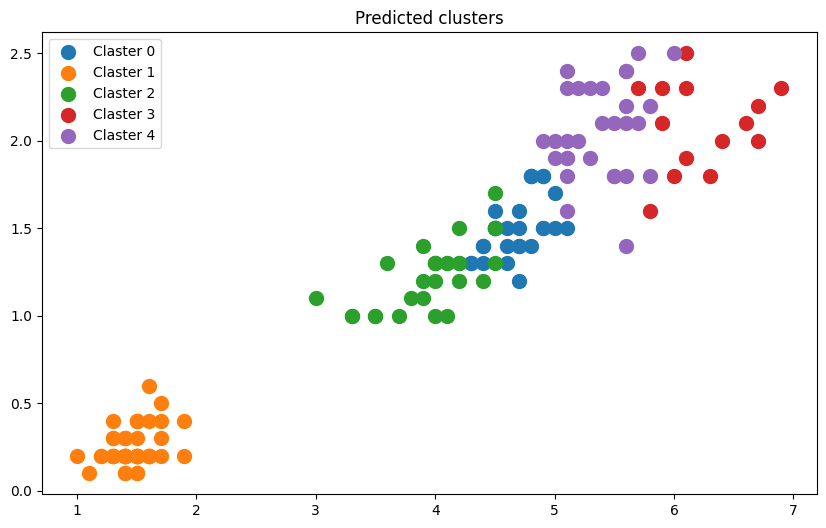

In [74]:
# Тут больше кластеров, чем 3
from sklearn.cluster import KMeans
hyper_try = hyper.copy()
hyper_try['KMeans']['n_clusters'] = 5
# hyper['KMeans']['']
kmeans = KMeans(**hyper_try['KMeans'])
clusters = kmeans.fit_predict(X_iris)

label_order = [2, 0, 1]

plot_clusters(X_iris, clusters, (2,3), title='Predicted clusters')

## DB-Scan

Описание параметров:

1) Eps - радиус, который рисуется вокруг каждой точки.
2) min_samples - количество точек, которые попадают в круг, необходимое для определения текущей точки как `core` точки. Должно быть `num_features + 1`

## Подбор параметров для кластеризации

Количество кластеров:  3
Количество 'шумных' точек:  30
F1 micro:  0.7266666666666666
F1 macro:  0.5932385618698857
F1 weighted:  0.7909847491598475




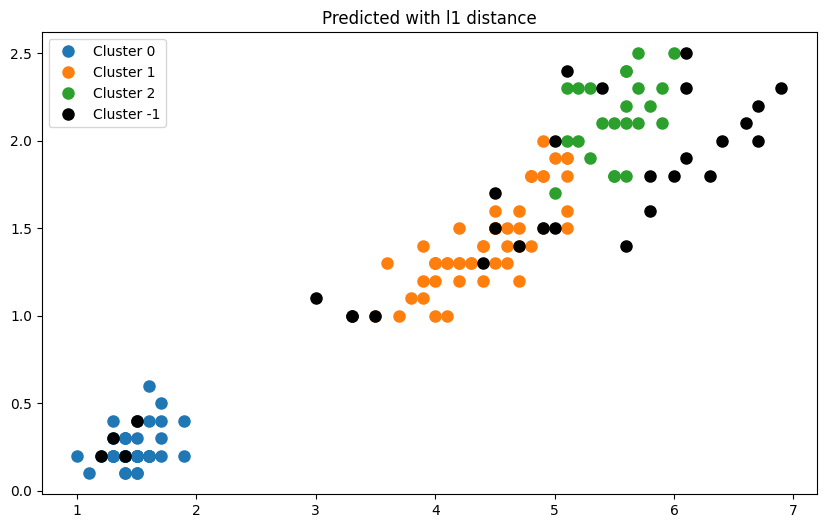

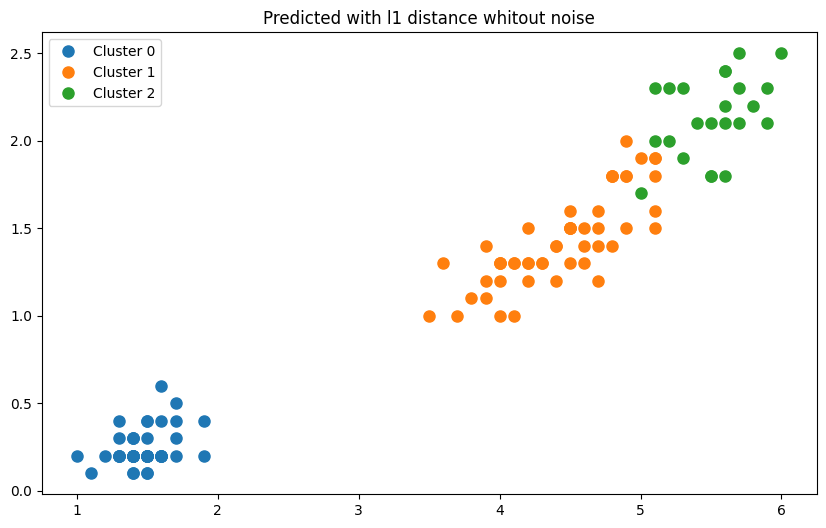

In [496]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.51, min_samples=12, metric='euclidean')
db = dbscan.fit(X_iris)
core_indexes = db.core_sample_indices_
clusters = db.labels_

mask_noise = np.zeros_like(clusters)
mask_noise = clusters != -1
corrected_clusters = hc_labels(clusters[mask_noise], label_order)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print("Количество кластеров: ", n_clusters_)
print("Количество 'шумных' точек: ", n_noise_)

print_f1_scores(y_iris, clusters)
plot_clusters(X_iris, clusters, (2,3), title=f'Predicted with l1 distance')
plot_clusters(X_iris[mask_noise, :], clusters[mask_noise], (2,3), title=f'Predicted with l1 distance whitout noise')

Количество кластеров:  2
Количество 'шумных' точек:  0
F1 micro:  0.6666666666666666
F1 macro:  0.5555555555555555
F1 weighted:  0.5555555555555555




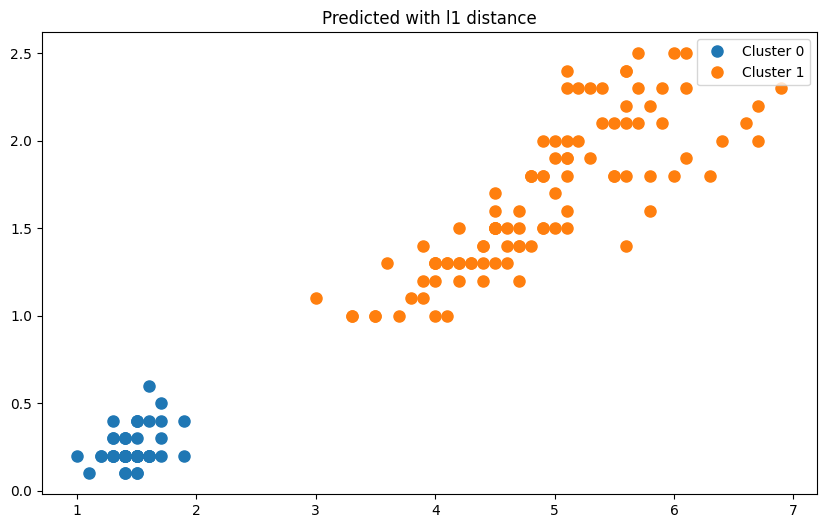

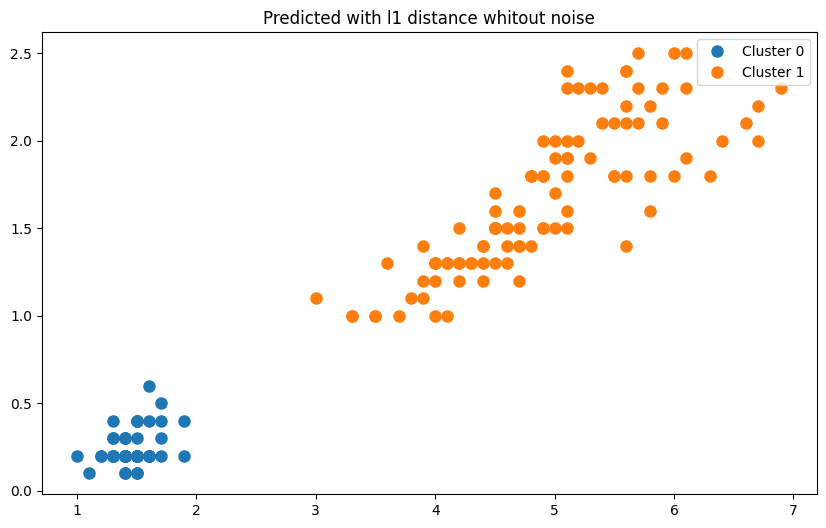

In [493]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=20, metric='manhattan')
db = dbscan.fit(X_iris)
core_indexes = db.core_sample_indices_
clusters = db.labels_

mask_noise = np.zeros_like(clusters)
mask_noise = clusters != -1
corrected_clusters = hc_labels(clusters[mask_noise], label_order)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print("Количество кластеров: ", n_clusters_)
print("Количество 'шумных' точек: ", n_noise_)

print_f1_scores(y_iris, clusters)
plot_clusters(X_iris, clusters, (2,3), title=f'Predicted with l1 distance')
plot_clusters(X_iris[mask_noise, :], clusters[mask_noise], (2,3), title=f'Predicted with l1 distance whitout noise')

## Сравнение разных функций расстояния

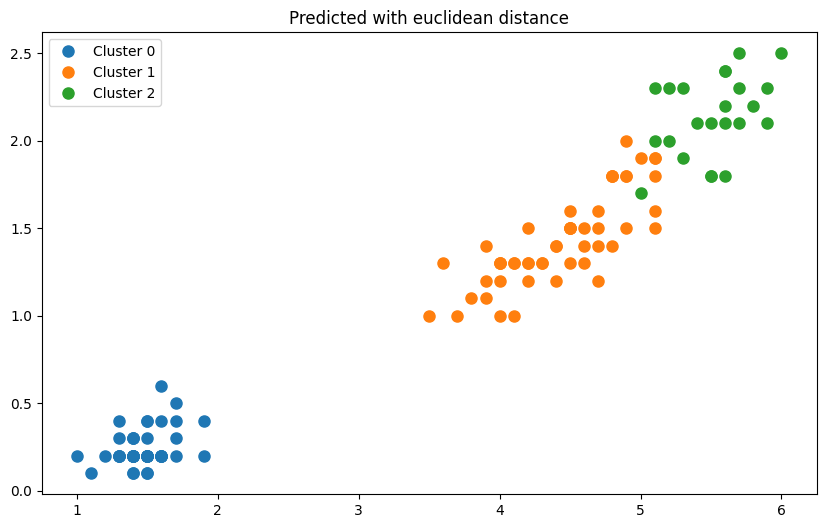

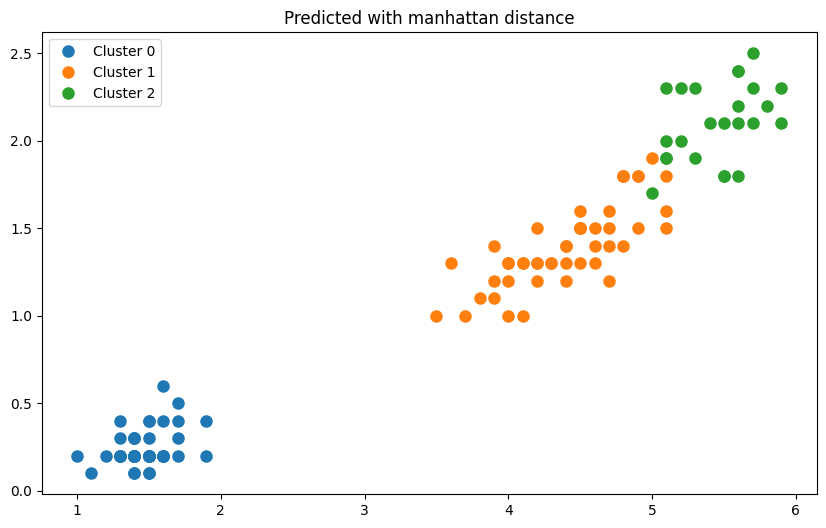

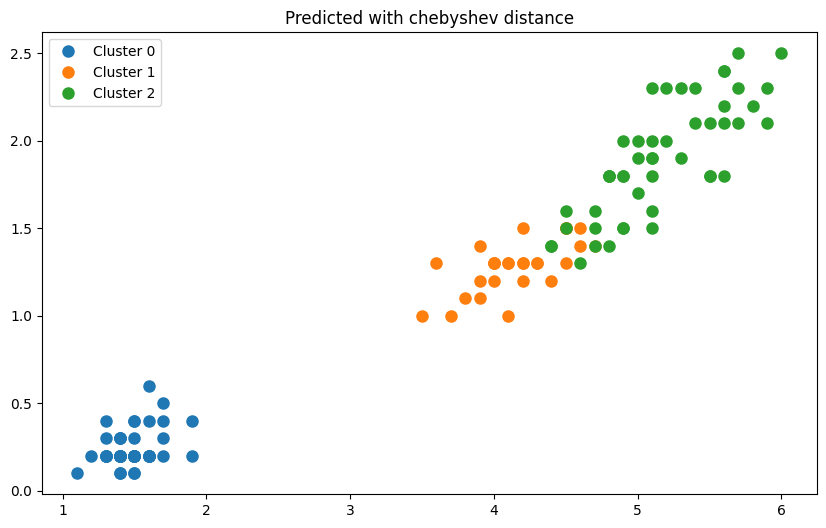

,eps,min_sample,f1,number of clusters,noise points
euclidean,0.51,12.0,0.593239,3.0,30.0
manhattan,0.88,12.0,0.609795,3.0,30.0
chebyshev,0.30,7.0,0.589799,3.0,29.0


In [489]:
from sklearn.cluster import DBSCAN

label_order = [2, 0, 1]
parameters = {
    'euclidean': [0.51, 12],
    'manhattan': [0.88, 12],
    'chebyshev': [0.3, 7]
    
}
cluster_metrics = {}

for metric_type in parameters:
    eps, min_sample = parameters.get(metric_type)
    dbscan = DBSCAN(eps=eps, min_samples=min_sample, metric=metric_type)
    db = dbscan.fit(X_iris, y_iris)
    clusters = db.labels_

    mask_noise = np.zeros_like(clusters)
    mask_noise = clusters != -1
    corrected_clusters = hc_labels(clusters[mask_noise], label_order)

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)

    plot_clusters(X_iris[mask_noise], clusters[mask_noise], (2,3), title=f'Predicted with {metric_type} distance')
    f1 = f1_score(y_iris, clusters, average='macro')

    cluster_metrics.update(
        {
            metric_type: {'eps': eps, 'min_sample': min_sample, 'f1': f1, 'number of clusters': n_clusters, 'noise points': n_noise}
        }
    )

pd.DataFrame(cluster_metrics).T

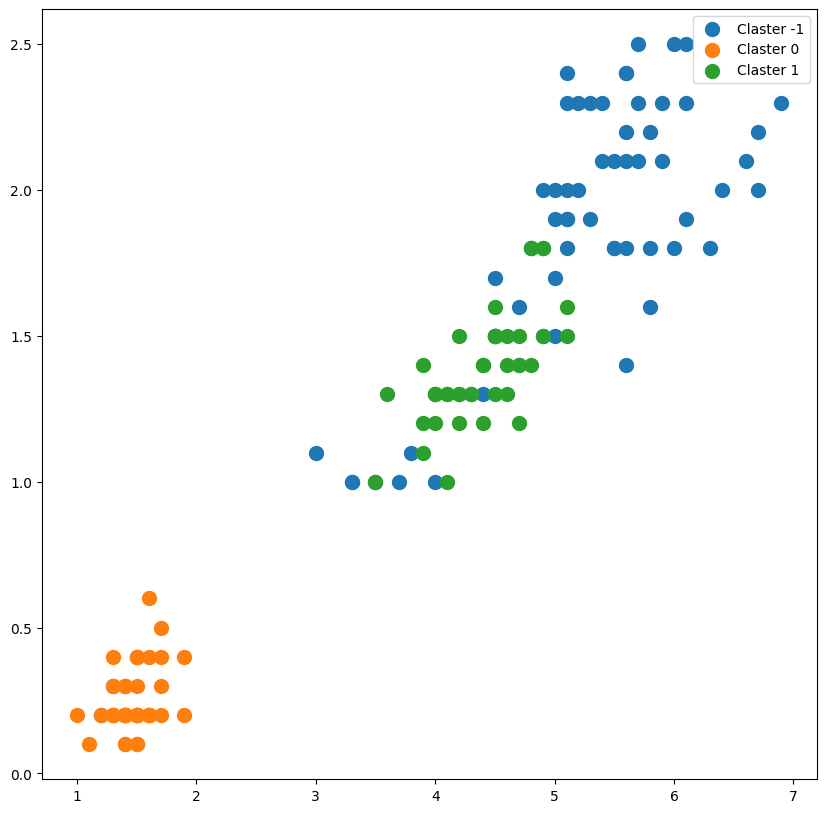

In [48]:

dbscan = DBSCAN(eps=0.261, min_samples=16, metric='l1') # f1 = 0.86
# dbscan = DBSCAN(eps=0.261, min_samples=16, metric='manhattan') # f1 = 0.86
# dbscan = DBSCAN(eps=0.009, min_samples=10, metric='cosine') # f1 = 0.86
clusters = dbscan.fit_predict(X_normed, y_iris)

plot_clusters(X_iris, clusters, (2, 3))

Выводы: ДБСкан склонен определять некоторые точки как шум. В нашем датасете наблюдалась картина, если мы стараемся избавиться от шумных точек, то он объединяет два кластера в один.

При увеличении количетсва точек, которые должны попасть в круг, необходимо уменьшать радиус этого круга.

## Иерархическая кластеризация

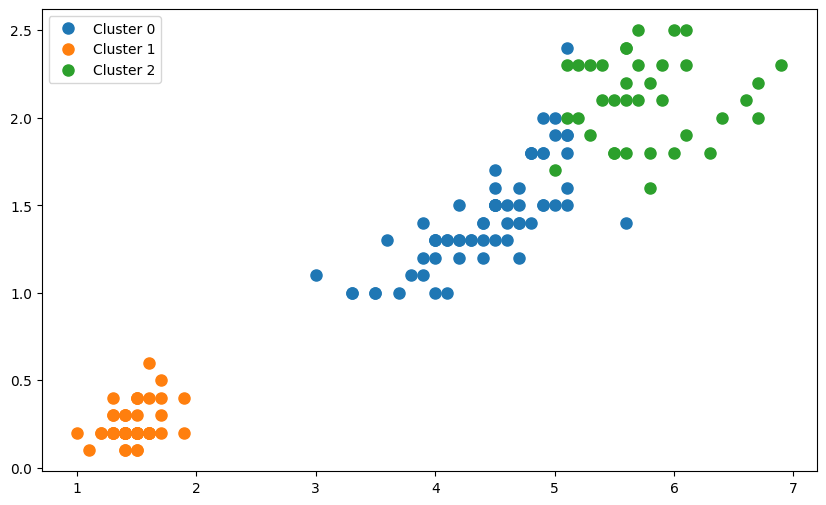

In [448]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=7)
clusters = agg_clustering.fit_predict(X_iris, y_iris)

plot_clusters(X_iris, clusters, (2,3))

0.8933333333333333


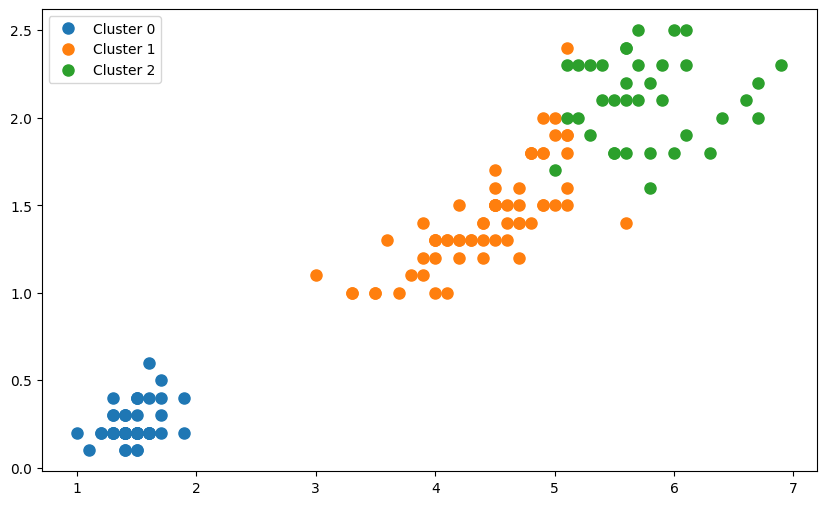

In [449]:
corrected_clusters = np.zeros_like(clusters)
corrected_clusters[clusters == 0] = 1
corrected_clusters[clusters == 1] = 0
corrected_clusters[clusters == 2] = 2
f1 = f1_score(y_iris, corrected_clusters, average='micro')
print(f1)
plot_clusters(X_iris, corrected_clusters, (2,3))


0.8933333333333333


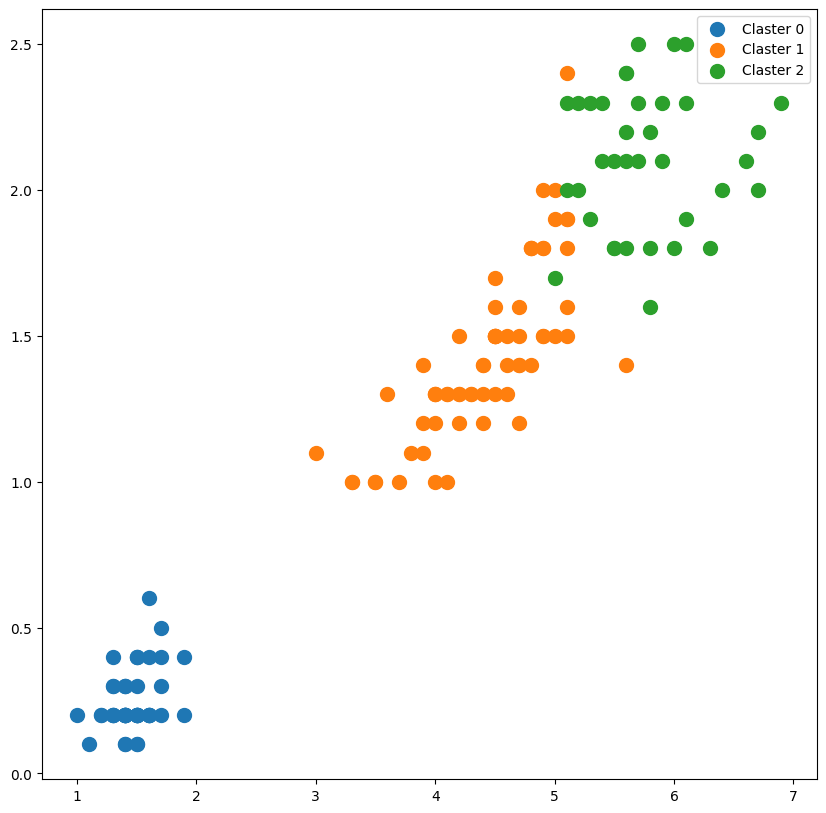

In [78]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3, compute_full_tree=False, distance_threshold=None)
clusters = agg_clustering.fit_predict(X_iris, y_iris)

# plot_clusters(X_iris, clusters, (2,3))
corrected_clusters = np.zeros_like(clusters)
corrected_clusters[clusters == 0] = 1
corrected_clusters[clusters == 1] = 0
corrected_clusters[clusters == 2] = 2
f1 = f1_score(y_iris, corrected_clusters, average='micro')
print(f1)
plot_clusters(X_iris, corrected_clusters, (2,3))

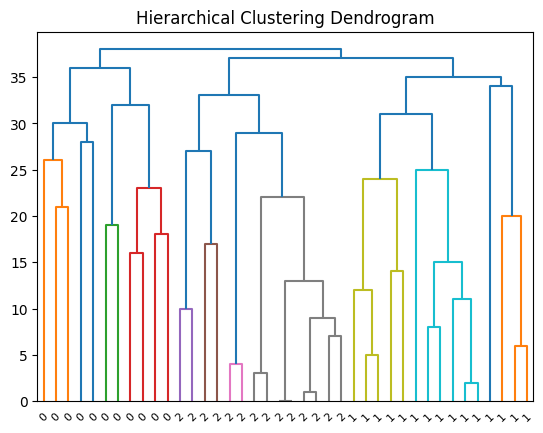

In [86]:
# https://stackoverflow.com/questions/29127013/plot-dendrogram-using-sklearn-agglomerativeclustering

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
x = iris.data[:40]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(x)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()